# Compare PERSIANN, CHIRPS and MSWEP for overlapping years and years with lots of missing data

In [1]:
# in sidebar: import regionmask, Cartopy, netcdf4, statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
%matplotlib inline
import os, glob 
import math
import xarray as xr
import regionmask as regionmask
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4


/apps/brussel/CO7/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Functions

In [2]:
from functions import *

/apps/brussel/CO7/broadwell/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Open data

In [3]:
vsc_vo_data = os.environ['VSC_DATA_VO_USER']

# Precip data 
inDIR = os.path.join(vsc_vo_data, 'Thesis')
PERSIANN_path = os.path.join(inDIR, 'PERSIANN/PERSIANN-CDR_v01r01_1983_2020_remapped_owngrid_reorder_timelatlon.nc')
CHIRPS_path = os.path.join(inDIR, 'CHIRPS/chirps_pr_owngrid_1981_2022.nc')
MSWEP_path = os.path.join(inDIR, 'MSWEP/mswep_pr_owngrid_1979_2017.nc')

# Basin shapefile
WBM_path = os.path.join(vsc_vo_data, 'Thesis/WBM-git') 
filepath_shp_basin = os.path.join(WBM_path,'input_data', 'shapefiles', 'Watsub.shp' ) 

#output directories 
fig_path = os.path.join(vsc_vo_data, 'Thesis/figures/fig_jun23_cut1985_PERSIANN')

In [4]:
ncfile = PERSIANN_path
var = 'precipitation'
PERSIANN_raw = open_ncfile(ncfile, var)

ncfile = CHIRPS_path
var = 'precip'
CHIRPS_raw = open_ncfile(ncfile, var)

ncfile = MSWEP_path
var = 'precipitation'
MSWEP_raw =  open_ncfile(ncfile, var)

['precipitation']
['time', 'lat', 'lon']
['precip']
['time', 'lon', 'lat']
['precipitation']
['time', 'lon', 'lat']


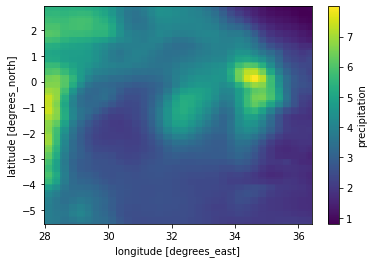

In [5]:
PERSIANN_raw.mean(dim='time').plot()

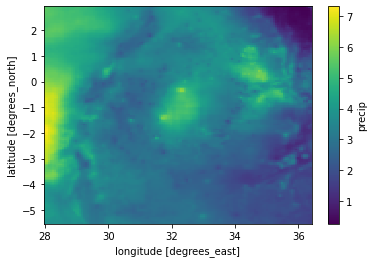

In [6]:
CHIRPS_raw.mean(dim='time').plot()

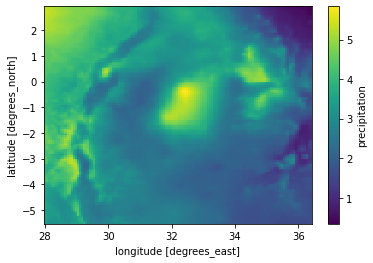

In [7]:
MSWEP_raw.mean(dim='time').plot()

In [8]:
PERSIANN_raw.coords

Coordinates:
  * time     (time) datetime64[ns] 1983-01-01 1983-01-02 ... 2020-12-31
  * lat      (lat) float64 -5.5 -5.435 -5.37 -5.305 ... 2.69 2.755 2.82 2.885
  * lon      (lon) float64 28.0 28.07 28.13 28.2 ... 36.19 36.26 36.32 36.38

In [9]:
CHIRPS_raw.coords

Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * lon      (lon) float64 28.0 28.07 28.13 28.2 ... 36.19 36.26 36.32 36.38
  * lat      (lat) float64 -5.5 -5.435 -5.37 -5.305 ... 2.69 2.755 2.82 2.885

In [10]:
MSWEP_raw.coords

Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 2017-10-31T12:00:00
  * lon      (lon) float64 28.0 28.07 28.13 28.2 ... 36.19 36.26 36.32 36.38
  * lat      (lat) float64 -5.5 -5.435 -5.37 -5.305 ... 2.69 2.755 2.82 2.885

In [11]:
CHIRPS_raw.time[0].dt.year

<xarray.DataArray 'year' ()>
array(1981)
Coordinates:
    time     datetime64[ns] 1981-01-01

In [12]:
CHIRPS_raw.time[-1].dt.year

<xarray.DataArray 'year' ()>
array(2022)
Coordinates:
    time     datetime64[ns] 2022-12-31

## Cut to full years 

In [13]:
def cut_full_years(da):
    
    if da.time[-1].dt.dayofyear < 365:
        i_end = -2
    else:
        i_end = -1
    if da.time[0].dt.dayofyear > 1:
        i_start = 1
    else:
        i_start = 0 
        
        da_out = da.sel(time=slice("{}-01-01".format(np.unique(da.time.dt.year)[i_start]), "{}-12-31".format(np.unique(da.time.dt.year)[i_end])))
    
    print(np.unique(da.time.dt.year)[i_start], np.unique(da.time.dt.year)[i_end])
    return da_out

In [14]:
CHIRPS_raw = cut_full_years(CHIRPS_raw)
MSWEP_raw = cut_full_years(MSWEP_raw)

1981 2022
1979 2016


# Plot yearly accumulations

## a) in whole square study aerea

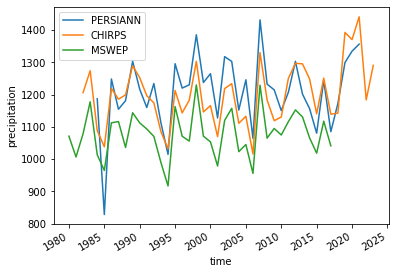

In [15]:
fig, ax = plt.subplots()

PERSIANN_raw.mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='PERSIANN')
CHIRPS_raw.mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='CHIRPS')
MSWEP_raw.mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='MSWEP')

plt.legend()

## b) only in basin

Quite similar! Precipitation in 1984 was very low in all datasets, and PERSIANN has higher precip in the basin than the other datasets for most of the timeseries

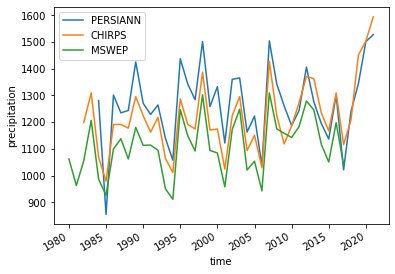

In [19]:
fig, ax = plt.subplots()

mask_da(PERSIANN_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='PERSIANN')
mask_da(CHIRPS_raw.sel(time=slice("1981-01-01", "2020-12-31")), filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='CHIRPS')
mask_da(MSWEP_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='MSWEP')

plt.legend()

## Count number of nan days

In [17]:
nandays_PER = find_nan(PERSIANN_raw)
print(len(nandays_PER))

nandays_CHI = find_nan(CHIRPS_raw)
print(len(nandays_CHI))

nandays_MSW = find_nan(MSWEP_raw)
print(len(nandays_MSW))

419
0
0


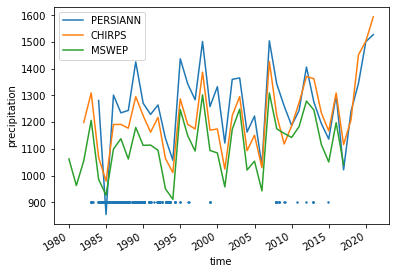

In [20]:
fig, ax = plt.subplots()

mask_da(PERSIANN_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='PERSIANN')
mask_da(CHIRPS_raw.sel(time=slice("1981-01-01", "2020-12-31")), filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='CHIRPS')
mask_da(MSWEP_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='MSWEP')

plt.scatter(nandays_PER, np.repeat(900, len(nandays_PER)), s=2)


plt.legend()

In [21]:
df_ndays = count_daysperyear(nandays_PER)
#df_ndays.index = pd.to_datetime([str('{}-12-31'.format(year)) for year in df_ndays.index], format='%Y-%m-%d')
df_ndays

,ndays
year,
1983,10.0
1984,127.0
1985,19.0
1986,39.0
1987,21.0
1988,30.0
1989,35.0
1990,34.0
1991,5.0


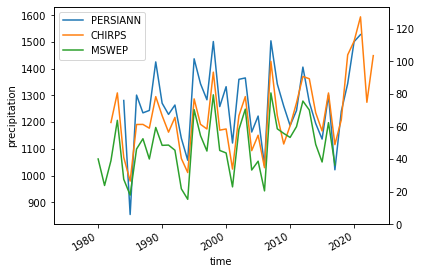

In [22]:

fig, ax = plt.subplots()

mask_da(PERSIANN_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='PERSIANN')
mask_da(CHIRPS_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='CHIRPS')
mask_da(MSWEP_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().plot(ax=ax, label='MSWEP')

#ax.plot(mask_da(PERSIANN_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum().to_dataframe())

ax2 = ax.twinx()
ax2.bar(df_ndays.index, df_ndays.ndays)
#df_ndays.plot(kind='bar',ax=ax2)

ax.legend()
plt.show()



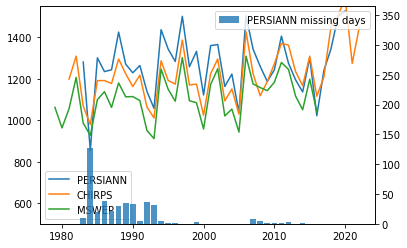

In [23]:
fig, ax = plt.subplots()

data = mask_da(PERSIANN_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum()
ax.plot(data.time.dt.year, data, label='PERSIANN')

data = mask_da(CHIRPS_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum()
ax.plot(data.time.dt.year, data, label='CHIRPS')

data=mask_da(MSWEP_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum()
ax.plot(data.time.dt.year, data, label='MSWEP')

ax.set_ylim(500,1550)

ax2 = ax.twinx()
ax2.bar(df_ndays.index, df_ndays.ndays, label='PERSIANN missing days', alpha=0.8)
ax2.set_ylim(0,365)

ax.legend()
ax2.legend()
plt.show()


## Remake SI figure with comparison of different data sources

Text(0.0, 1.0, '(c)')

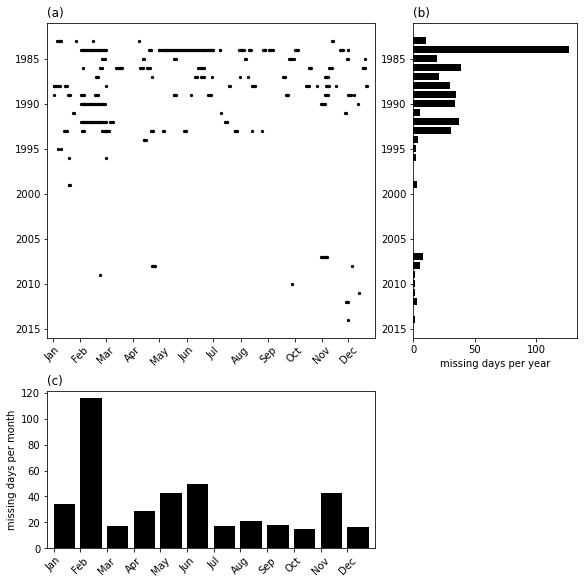

In [24]:
fig = plt.figure( figsize = (8, 8), layout="constrained") 

df_ndays = count_daysperyear(nandays_PER)
df_ndays_month = count_dayspermonth(nandays_PER)
nan_days = nandays_PER
list_ticks, list_monthnames = make_month_xaxis_labels_ticks()

# scatterplot days each year
ax1 = plt.subplot2grid((6, 3), (0, 0), colspan=2, rowspan=4)
ax1.scatter(nan_days.dayofyear, nan_days.year, s=5, c='k')

# labels
ax1.set_xlim(-6,365)
ax1.set_xticks(list_ticks, list_monthnames, rotation = 45)
ax1.invert_yaxis()
ax1.set_title('(a)', loc='left')

# number of days per year
ax2 = plt.subplot2grid((6, 3), (0, 2), colspan=1, rowspan=4, sharey = ax1)
ax2.barh(df_ndays.index, df_ndays.ndays, color='k')
ax2.set_xlabel('missing days per year')
ax2.set_title('(b)', loc='left')

# number of days per month
ax3 = plt.subplot2grid((6, 3), (4, 0), colspan=2, rowspan=4)
ax3.bar(df_ndays_month.index, df_ndays_month.ndays, color = 'k', align='edge') # 
ax3.set_xticks(range(1,13), list_monthnames, rotation = 45)
#ax3.set_xticks(np.arange(1.5, 13.5, 1), list_monthnames, rotation = 45)
ax3.margins(x=0.02)
ax3.set_ylabel('missing days per month')
ax3.set_title('(c)', loc='left')

#plt.savefig(os.path.join(fig_path,'PERSIANN_nandays.pdf'),dpi=300)
#plt.savefig(os.path.join(fig_path,'PERSIANN_nandays.png'),dpi=300)

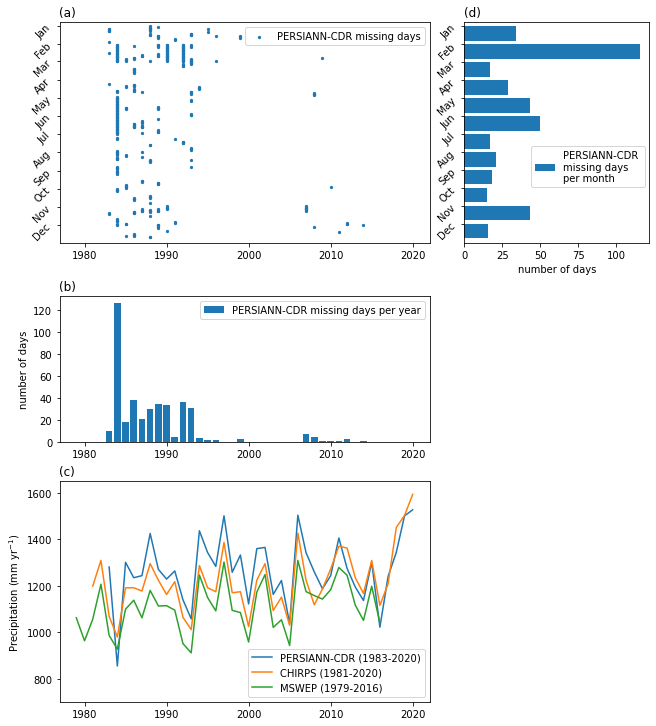

In [28]:
fig = plt.figure( figsize = (9, 11), layout="constrained") 

df_ndays = count_daysperyear(nandays_PER)
df_ndays_month = count_dayspermonth(nandays_PER)
nan_days = nandays_PER
list_ticks, list_monthnames = make_month_xaxis_labels_ticks()

# scatterplot days each year
ax1 = plt.subplot2grid((9, 3), (0, 0), colspan=2, rowspan=3)
ax1.scatter(nan_days.year, nan_days.dayofyear, s=5, label = 'PERSIANN-CDR missing days')

# labels
ax1.set_ylim(-6,365)
ax1.set_yticks(list_ticks, list_monthnames, rotation = 45)
ax1.invert_yaxis()
ax1.set_title('(a)', loc='left')

# number of days per month
ax2 = plt.subplot2grid((9, 3), (0, 2), colspan=1, rowspan=3)
ax2.barh(df_ndays_month.index, df_ndays_month.ndays, align='edge', label='PERSIANN-CDR \nmissing days \nper month') 
ax2.set_yticks(range(1,13), list_monthnames, rotation = 45)
ax2.margins(y=0.02)
ax2.invert_yaxis()
#ax2.set_xlabel('missing days per month')
ax2.set_xlabel('number of days')
ax2.set_title('(d)', loc='left')

# number of days per year
ax3 = plt.subplot2grid((9, 3), (3, 0), colspan=2, rowspan=2, sharex=ax1)
ax3.bar(df_ndays.index, df_ndays.ndays, label='PERSIANN-CDR missing days per year')
#ax3.set_ylabel('missing days per year')
ax3.set_ylabel('number of days')
ax3.set_title('(b)', loc='left')

# compare with other data sources
ax4 = plt.subplot2grid((9, 3), (5, 0), colspan=2, rowspan=3, sharex=ax1)

data = mask_da(PERSIANN_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum()
ax4.plot(data.time.dt.year, data, label='PERSIANN-CDR ({}-{})'.format(data.time.dt.year[0],data.time.dt.year[-1]))
data = mask_da(CHIRPS_raw.sel(time=slice("1981-01-01", "2020-12-31")), filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum()
ax4.plot(data.time.dt.year, data, label='CHIRPS ({}-{})'.format(data.time.dt.year[0],data.time.dt.year[-1]))
data=mask_da(MSWEP_raw, filepath_shp_basin).mean(dim=['lat', 'lon']).resample(time='Y', label='right').sum()
ax4.plot(data.time.dt.year, data, label='MSWEP ({}-{})'.format(data.time.dt.year[0],data.time.dt.year[-1]))

ax4.set_ylabel('Precipitation (mm yr$^{-1}$)')
ax4.set_title('(c)', loc='left')
ax4.set_ylim(700, 1650)

ax1.legend(loc='upper right')
ax2.legend(loc=(0.36,0.25))
ax3.legend(loc='upper right')
ax4.legend() #loc='upper left', bbox_to_anchor=(1,1)

#plt.savefig(os.path.join(fig_path,'PERSIANN_nandays_cfr_MSWEP_CHIRPS_v2.pdf'),dpi=300)
#plt.savefig(os.path.join(fig_path,'PERSIANN_nandays_cfr_MSWEP_CHIRPS_v2.png'),dpi=300)

In [29]:
fig_path

'/data/brussel/vo/000/bvo00012/vsc10419/Thesis/figures/fig_jun23_cut1985_PERSIANN'